In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf         # No outro arquivo eu uso um CSV achado no Kaggle. Porém, gostaria de aprender a usar o yf.
from datetime import datetime
from tqdm import tqdm

# Bala de Markowitz (artificial)
Nesta parte do código, iremos gerar a bala de markowitz.  
Para isso, iremos gerar aleatóriamente 5 ações e covariâncias.  
Tomarei todo cuidado, para que os pesos da carteira sejam sorteados de forma uniforme (sortear em um simplexo).

In [2]:
def Gerar_positive_matrix(n):   # Por definição, uma matriz de covariância precisa ser positiva definida.
    """Gera uma matrix nxn positiva definida.
    int -> matrix"""
    A = np.random.rand(n, n)            # Cria uma matrix com entradas aleatórias uniformemente distribuídas entre [0, 1)
    A_tri = np.tril(A)                  # Ele zera todas as entradas acima da diagonal principal da matrix

    sp_matrix = np.dot(A_tri, A_tri.T)  # Usando a fatoração de cholesky, criamos essa matrix positiva definida

    return sp_matrix


def Sortear_pesos(n):   # Método de sorteio em um simplexo. Possui distribuição uniforme.
    """Gera um array no Rn, de forma uniforme, onde suas entradas somam 1
    int -> array"""
    aleatorio = [0]
    for _ in range(1, n):
        aleatorioi = np.random.rand()  # Gero números entre [0, 1) uniformemente
        aleatorio.append(aleatorioi)    # Os adiciono a lista.
    aleatorio.sort()                    # Ordeno-a
    aleatorio.append(1)

    pesos = np.array(aleatorio[1:]) - np.array(aleatorio[:-1])
    
    return pesos


def simula(acoes, n=20000):
    """Dada a quantidade de ações, retorna o risco, e o retorno de n carteiras, com o intuito de fazer a bala de markowitz.
    int, int -> array, array"""
    matrix_covariancia = Gerar_positive_matrix(acoes)  # Gera a matrix de covariância
    variancia_acoes = np.diag(matrix_covariancia)           # Pega a variância das ações 

    retorno_acoes = np.random.rand(acoes, 1)                # Gera o retorno das ações

    variancia_carteira = []
    retorno_carteira = []

    for _ in range(0, n):
        pesos = Sortear_pesos(acoes)                        # Sorteia os pesos i
        
        retorno = retorno_acoes.T@pesos                     # Faz o retorno da carteira i
        retorno_carteira.append(retorno)

        variancia = pesos.T@matrix_covariancia@pesos        # Faz a variância da carteira i
        variancia_carteira.append(variancia)
    

    return variancia_carteira, retorno_carteira, variancia_acoes, retorno_acoes

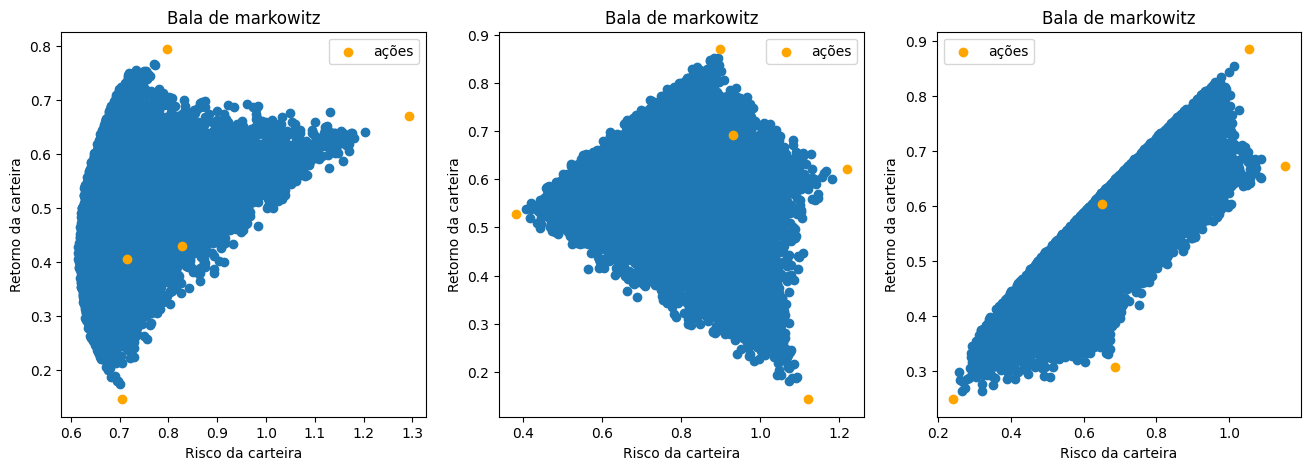

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

for ax in axs:
    variancia_bala, retorno_bala, variancia_acoes, retorno_acoes = simula(5)

    risco_bala = np.sqrt(variancia_bala)
    risco_acoes = np.sqrt(variancia_acoes)

    ax.scatter(risco_bala, retorno_bala)
    ax.scatter(risco_acoes, retorno_acoes, color='orange',label='ações')

    ax.set_title('Bala de markowitz')
    ax.set_xlabel('Risco da carteira')
    ax.set_ylabel('Retorno da carteira')

    ax.legend()

plt.show()

É possível perceber a razão da nossa bala de markowitz não parecer tanto uma bala.  
As nossas ações e sua covariância são geradas aleatoriamentes, e para a bala ficar realmente parecendo uma bala, as ações e as covariâncias deveriam cair de uma forma 'bonitinha'.

# Teoria de Markowitz

Nesta parte do código, iremos testar a teoria de markowitz.  
Para isso, iremos pegar 10 ações do mercado brasileiro de setores distintos, para que não possuam tanta covariância.  
Iremos fazer a bala de markowitz com essas ações, e pintar sua fronteira ótima.

### Pegando os dados e fazendo a bala

In [4]:
def retorno_diario(acao):
    """Dado os valores de aberturas de uma ação retorna o array com os retornos diário, 
    o retorno diário médio, a variância, e o desvio padrão dos retornos.
    array -> float)"""
    
    ret = (acao[1:] - acao[:-1]) / acao[:-1]  # Criando o array com os retornos diários
    
    media = np.mean(ret) # Retorno médio

    return media

    
def simula_teoria(tickers, retornos, matrix_covariancia, n=20000):
    """Dada a quantidade de ações, retorna o risco, e o retorno de n carteiras, com o intuito de fazer a bala de markowitz.
    array, array, array, int -> array, array"""

    variancia_carteira = []
    retorno_carteira = []

    for _ in range(0, n):
        pesos = Sortear_pesos(len(tickers))                        # Sorteia os pesos i
        
        retorno = np.dot(retornos.T, pesos)                     # Faz o retorno da carteira i
        retorno_carteira.append(retorno)

        variancia = pesos.T@matrix_covariancia@pesos        # Faz a variância da carteira i
        variancia_carteira.append(variancia)
    

    return variancia_carteira, retorno_carteira

In [5]:
startDate = datetime(2019, 1, 1)    # Definindo que queremos pegar o histórico
endDate = datetime(2021, 1, 1)

tickers = ['TIMS3',     # Tim          - telefonia
            'SLCE3',    # SLC agrícola - agricultura
            'SMTO3',    # São martinho - eletricidade
            'BEEF3',    # Minervafoods - comida
            'AMAR3',    # Americanas   - Loja de venda
            'YDUQ3',    # YDUQS PART   - educação
            'CSNA3',    # CSN          - insumos básicos
            'RADL3',    # DrogariaRaia - Farmácia
            'ABEV3',    # Ambev        - Cerveja
            'RAIL3']    # RumoLogística- Transporte
aberturas = []

for ticker in tickers:
    acao = yf.Ticker(ticker +'.SA') # O yahoofinance pede que as ações tenham .SA no final
    valor_abertura = acao.history(start=startDate, end=endDate)['Open']
    aberturas.append(np.array(valor_abertura))

covariancia = np.cov(aberturas) # Utiliza n-1 na fórmula. (Covariância da amostra)

retornos_acoes = []
for acao in aberturas:  # Pega o retorno médio das ações
    retorno = retorno_diario(acao)
    retornos_acoes.append(retorno)

retornos_acoes = np.array(retornos_acoes)

In [6]:
variancia_bala, retorno_bala = simula_teoria(tickers, retornos_acoes, covariancia, n=300000)    # Simula as carteiras da bala

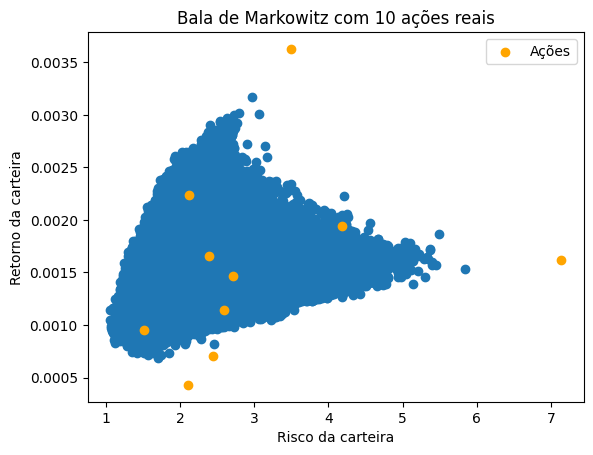

In [7]:
stdev_bala = np.sqrt(variancia_bala)    # Pega o risco(desvio-padrão) da carteira

variancia_acoes = np.diag(covariancia)  # A variância das ações é a diagonal da matriz da covariancia
stdev_acoes = np.sqrt(variancia_acoes)  # Pega o risco(desvio-padrão) das ações

plt.scatter(stdev_bala, retorno_bala)
plt.scatter(stdev_acoes, retornos_acoes, color='orange', label='Ações')

plt.xlabel('Risco da carteira')
plt.ylabel('Retorno da carteira')
plt.title('Bala de Markowitz com 10 ações reais')

plt.legend()
plt.show()

Aqui já podemos perceber um problema muito famoso da teoria de markowitz em seu estado original, ele tende a se concentrar em algumas ações.

### Pintura da fronteira ótima

In [8]:
def criterio_sort_risco(a):   # Criando uma função que será usada no sort usando o risco como parâmetro para ordenar.
    return a[0]


def criterio_sort_retorno(a):   # Criando uma função que será usada no sort usando o retorno como parâmetro para ordenar.
    return a[1]


carteiras = [(Risco, Retorno) for Risco, Retorno in zip(stdev_bala, retorno_bala)]  # Criando um array que contém (risco, retorno)

In [9]:
h=5.5e-3                                            # O tamanho do nosso intervalo

carteiras.sort(key=criterio_sort_risco)             # Coloco as carteiras da bala de forma crescente com base no risco.
Risco_inicial = np.copy(carteiras[0][0])            # Risco mais baixo de toda bala.

carteiras.sort(key=criterio_sort_retorno)           # Coloco as carteiras da bala de forma crescente com base no retorno.
Risco_final = np.copy(carteiras[-1][0])             # Risco da carteira com o retorno mais alto, é o retorno que seria considerado o 'final'.
Riscos = np.arange(Risco_inicial, Risco_final+h, h) # Faço uma lista que vai do Risco Baixo ao Risco Alto com passo h

fronteira = []
for Risco in tqdm(Riscos):
    intervalo = []

    for carteira in carteiras:                      # O objetivo do loop, é pegar todos os pontos que se encontram dentro de um certo intervalo de risco.
        if Risco <= carteira[0] <= Risco + h:       # Para podermos descobrir qual ponto deste intervalo pertence a fronteira ótima.
            intervalo.append(carteira)

    if len(intervalo) != 0:
        intervalo.sort(key=criterio_sort_retorno)   # Organizamos o nosso intervalo de forma crescente com base no retorno.
        fronteira.append(intervalo[-1])             # Logo, o último elemento será aquele com o maior retorno.
        
fronteira = np.array(fronteira).T

100%|██████████| 349/349 [00:28<00:00, 12.15it/s]


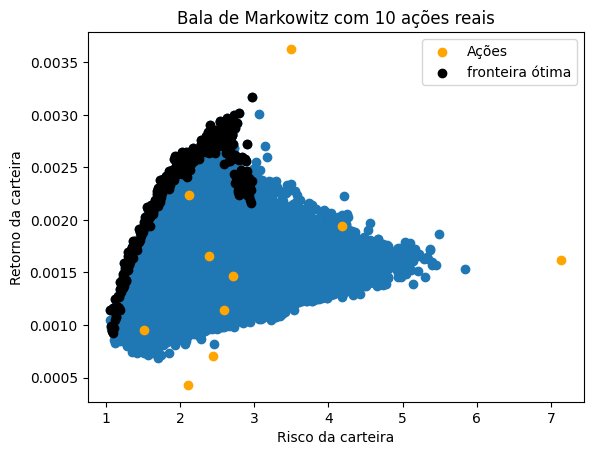

In [10]:
plt.scatter(stdev_bala, retorno_bala)
plt.scatter(stdev_acoes, retornos_acoes, color='orange', label='Ações')

plt.scatter(fronteira[0], fronteira[1], label='fronteira ótima', color='black')

plt.xlabel('Risco da carteira')
plt.ylabel('Retorno da carteira')
plt.title('Bala de Markowitz com 10 ações reais')

plt.legend()
plt.show()

Todo o algoritmo usado para pintar a fronteira ótima é de minha autoria.  
Logo, se existe alguma maneira conhecida e eficiente de se fazer, peço desculpas (Espero que quando você esteja lendo isso, eu já saiba como fazer a fronteira de maneira eficiente).